In [4]:
# !pip install scikit-learn

In [3]:
import os 
import re
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats 
from skimage import measure
import matplotlib.pyplot as plt
import json
import zarr

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

# set paths
sys.path.insert(0, '/code/src')
data_dir = '/data'

# package imports
from bci.loaders import load
from bci.thresholds.thresholds import align_thresholds
from bci.processing import processing
from bci.trials.align import indep_roll
from scipy import ndimage
from sklearn.model_selection import cross_validate

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import wilcoxon

In [4]:
md = load.load_filtered_metadata()
mouse_id = 754303
md = md[md['subject_id']==mouse_id]
sesh = md['name'].values[1]

# plot outlines

- slope of time per threshold condition
- ~plot of threshold over time~
- heatmap CN (and high weight N) across trials for intuition
- lick spout times over activity / ISI 

- ~zaber metric input explainer~

- distribution of model scores
    - shows across session weights change
    - become more / less predictable
    
- distribution of neuron weights, highlight CN (and max N?)
    - per third of sesh, does shift correspond to "task performance" / are there different modes of shift change

- 



# plot threshold over time for each session

In [8]:
# for sesh in session_list:
#     data = load.load_session_data(sesh)
#     mouse = sesh.split('_')[1]
#     date = sesh.split('_')[2]
#     raw_trials = data['bci_trials']
#     trials = processing.get_valid_bci_trials(raw_trials)
#     low = trials['low']
#     high = trials['high']
    
#     fig, ax = plt.subplots(figsize=(7, 7))
#     ax.plot(low, label='lower bound')
#     ax.plot(high, label='upper bound')
#     ax.set_ylim(0)
#     ax.grid(which='both', alpha=0.2)
#     ax.set_xlim(0)
#     ax.set_xlabel('n trials')
#     ax.set_ylabel('raw fluorescence')
#     ax.set_title(f'CN thresholds\n{mouse}_{date}')
#     ax.legend()
#     # plt.savefig(f'thresholds_{mouse}_{date}.png', bbox_inches='tight')
#     plt.close()
    


# svm read data

In [51]:
session_path_list = []
svm_results_path = '/data/camila_results_bci_workshop/'
for i in os.listdir(os.path.join(svm_results_path, str(mouse_id))):
    if i.startswith('s'):
        session_path_list.append(os.path.join(svm_results_path, str(mouse_id), i))

In [52]:
session_path_list

['/data/camila_results_bci_workshop/754303/single-plane-ophys_754303_2025-01-27_20-01-31_processed_2025-08-07_06-00-10',
 '/data/camila_results_bci_workshop/754303/single-plane-ophys_754303_2025-01-23_19-48-32_processed_2025-08-08_15-29-29',
 '/data/camila_results_bci_workshop/754303/single-plane-ophys_754303_2025-01-29_16-07-41_processed_2025-08-04_04-39-41',
 '/data/camila_results_bci_workshop/754303/single-plane-ophys_754303_2025-01-31_15-13-50_processed_2025-08-05_20-00-52',
 '/data/camila_results_bci_workshop/754303/single-plane-ophys_754303_2025-02-03_15-24-22_processed_2025-08-04_04-23-48']

In [61]:
result_path_list = []
for i in session_path_list:
    result_path_list.append(os.path.join(i, 'svm_sample', 'svm_results.h5'))
    
result_path_list = np.sort(result_path_list).tolist()

In [62]:
result_path_list

['/data/camila_results_bci_workshop/754303/single-plane-ophys_754303_2025-01-23_19-48-32_processed_2025-08-08_15-29-29/svm_sample/svm_results.h5',
 '/data/camila_results_bci_workshop/754303/single-plane-ophys_754303_2025-01-27_20-01-31_processed_2025-08-07_06-00-10/svm_sample/svm_results.h5',
 '/data/camila_results_bci_workshop/754303/single-plane-ophys_754303_2025-01-29_16-07-41_processed_2025-08-04_04-39-41/svm_sample/svm_results.h5',
 '/data/camila_results_bci_workshop/754303/single-plane-ophys_754303_2025-01-31_15-13-50_processed_2025-08-05_20-00-52/svm_sample/svm_results.h5',
 '/data/camila_results_bci_workshop/754303/single-plane-ophys_754303_2025-02-03_15-24-22_processed_2025-08-04_04-23-48/svm_sample/svm_results.h5']

In [63]:
path = result_path_list[0]

In [64]:
from bci.loaders import results
res = results.Results.from_python_hdf5(path)
print(res.__dict__.keys())
res.svc_coeff.shape

dict_keys(['pipeline', 'comment', '_Results__created', 'dff_by_trial_st_end', 'rois_idx', 'score_test', 'score_train', 'svc_coeff'])


(100, 3, 185)

In [65]:
def get_result_dict(path):
    from bci.loaders import results
    return results.Results.from_python_hdf5(path)

In [66]:
sesh_1 = get_result_dict(result_path_list[0])
sesh_2 = get_result_dict(result_path_list[1])
sesh_3 = get_result_dict(result_path_list[2])
sesh_4 = get_result_dict(result_path_list[3])
sesh_5 = get_result_dict(result_path_list[4])

In [67]:
sesh_dicts = [sesh_1, sesh_2, sesh_3, sesh_4, sesh_5]
for idx, s in enumerate(sesh_dicts):
    s.date = result_path_list[idx].split('_processed')[0][-19:-9]
    s.mouse_id = mouse_id
    s.n_trials = s.dff_by_trial_st_end.shape[1]

In [68]:
sesh_1.CN = 26
sesh_2.CN = 33
sesh_3.CN = 4
sesh_4.CN = 97
sesh_5.CN = 5

# ~svm neuron weights~
- ~distribution of neuron weights, highlight CN (and max N?)~
    - ~per third of sesh, does shift correspond to "task performance" / are there different modes of shift change~

In [69]:
session_dict = sesh_1
weights = session_dict.svc_coeff

In [70]:
weights.shape

(100, 3, 185)

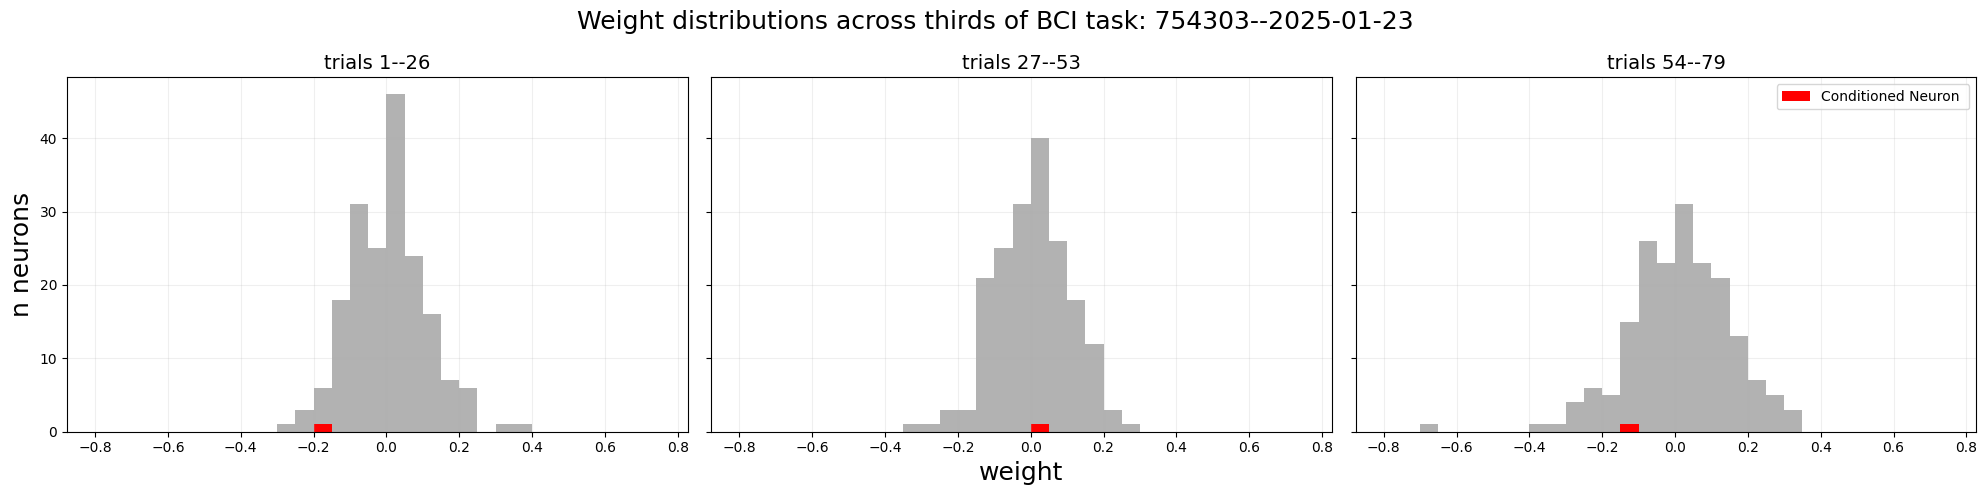

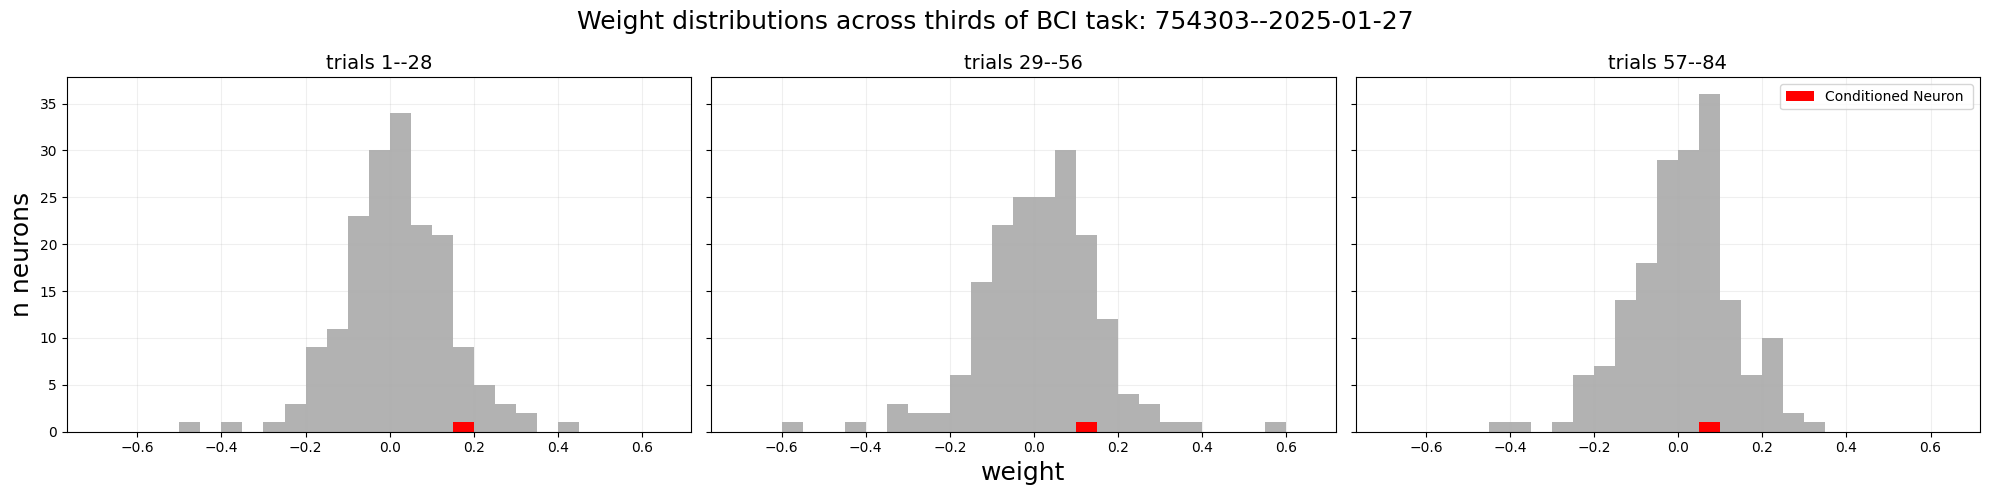

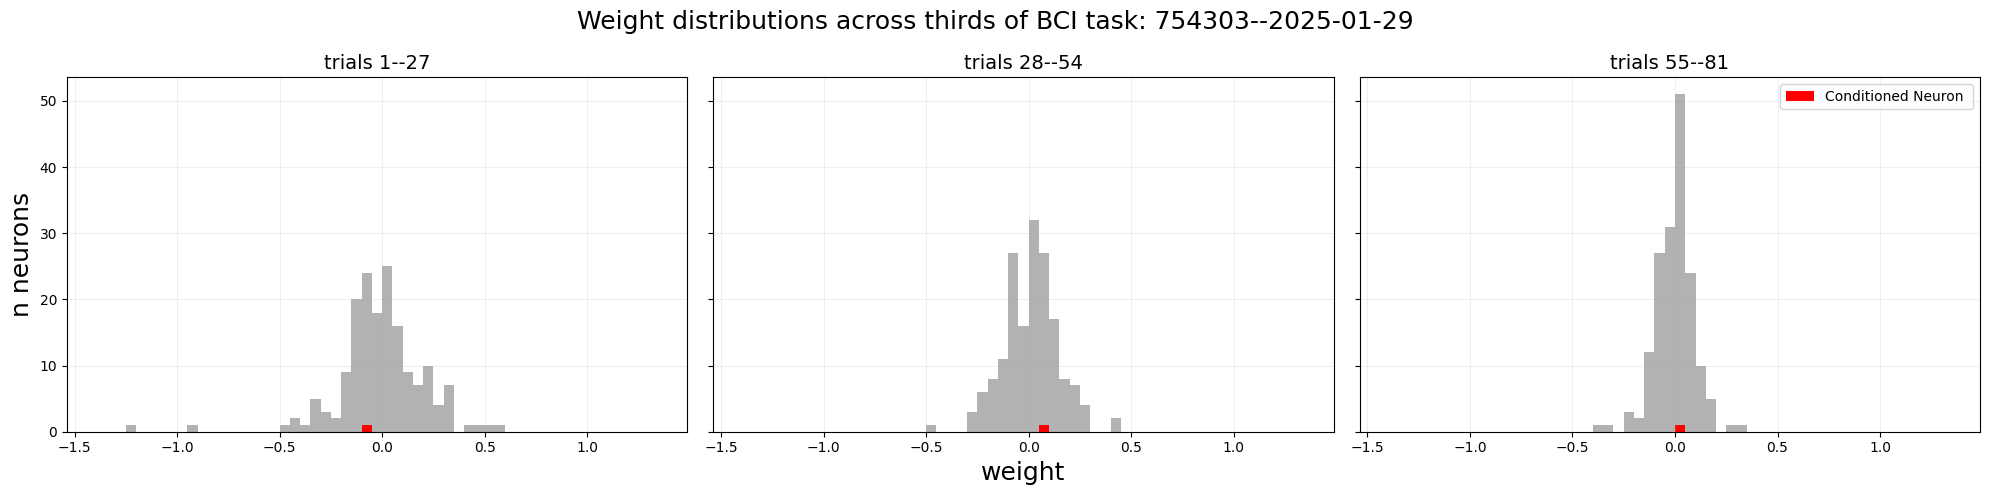

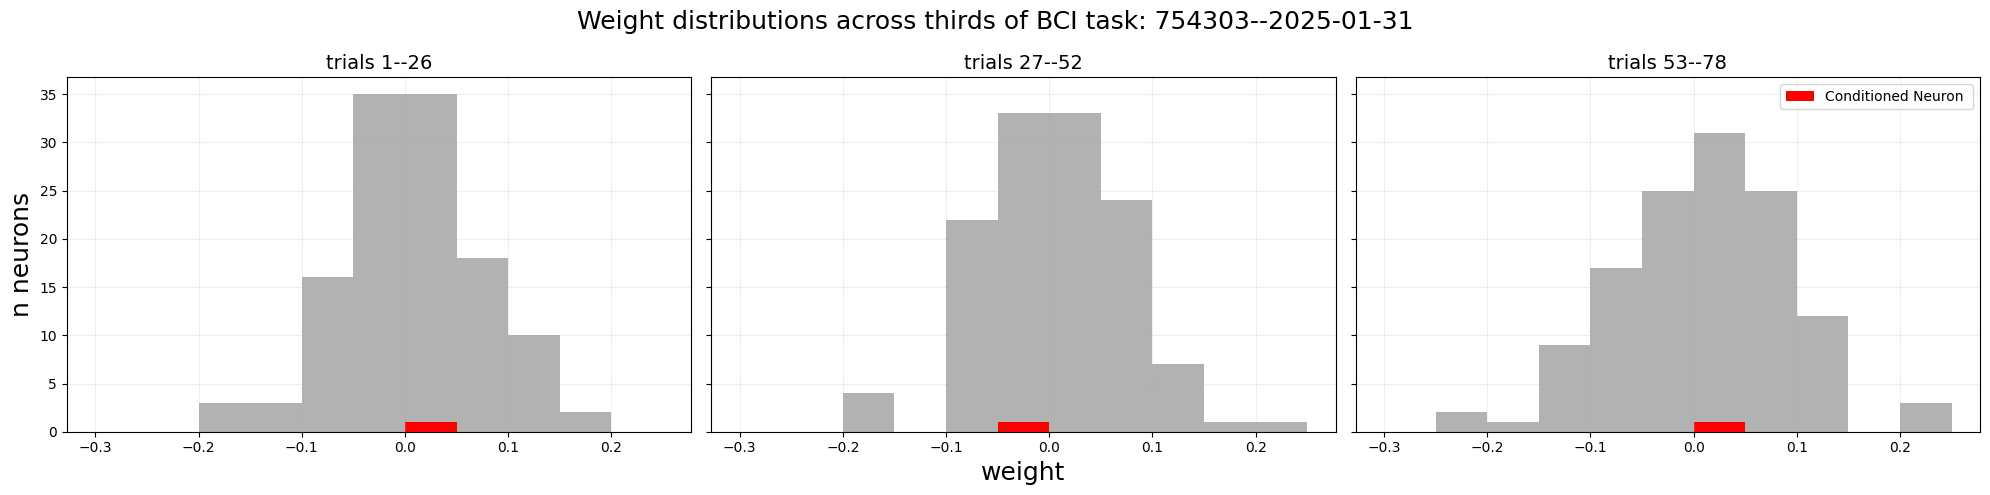

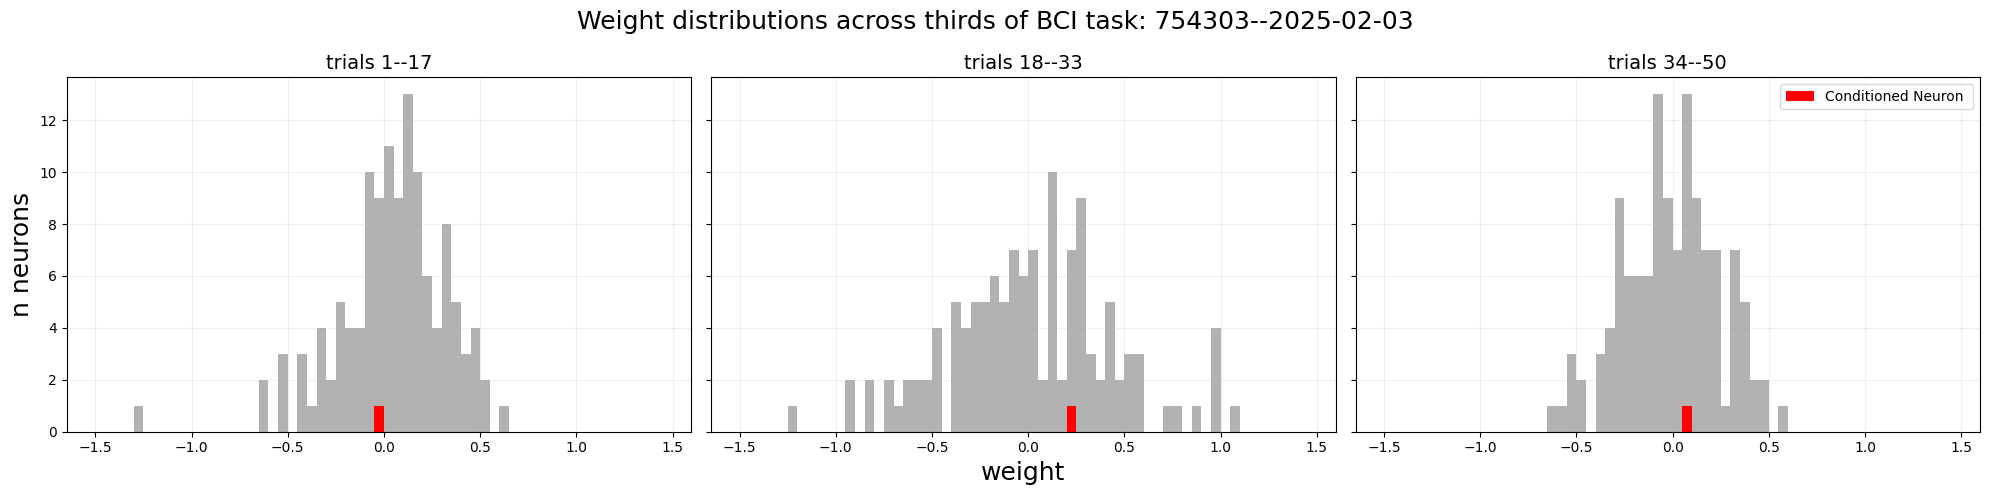

In [71]:
for session_dict in sesh_dicts:
    weights = session_dict.svc_coeff
    
    # tinker with binsize
    max_abs = np.round(np.max([np.max(weights), np.abs(np.min(weights))]), decimals=1)
    bins = np.arange(-max_abs, max_abs, 0.05)
    # for titles
    thirds = np.round(np.linspace(0, session_dict.n_trials, 4)).astype(int)
    thirds

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)

    # first third of trials
    ax1.hist(np.mean(weights, axis=0)[0], bins=bins, color='k', alpha=0.3)
    ax1.hist(np.mean(weights, axis=0)[0][session_dict.CN], bins=bins, color='r')
    ax1.set_title(f'trials 1--{thirds[1]}', fontsize=14)
    ax1.grid(which='both', alpha=0.2)
    ax1.set_ylabel('n neurons', fontsize=18)

    ax2.hist(np.mean(weights, axis=0)[1], bins=bins, color='k', alpha=0.3)
    ax2.hist(np.mean(weights, axis=0)[1][session_dict.CN], bins=bins, color='r')
    ax2.set_title(f'trials {thirds[1]+1}--{thirds[2]}', fontsize=14)
    ax2.grid(which='both', alpha=0.2)
    ax2.set_xlabel('weight', fontsize=18)


    ax3.hist(np.mean(weights, axis=0)[2], bins=bins, color='k', alpha=0.3,)
    ax3.hist(np.mean(weights, axis=0)[2][session_dict.CN], bins=bins, color='r', label='Conditioned Neuron ')
    ax3.set_title(f'trials {thirds[2]+1}--{thirds[3]}', fontsize=14)
    ax3.grid(which='both', alpha=0.2)

    plt.suptitle(f'Weight distributions across thirds of BCI task: {session_dict.mouse_id}--{session_dict.date}', fontsize=18)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'{os.getcwd()}/weight_distributions/{session_dict.mouse_id}_{session_dict.date}.png', dpi=200, bbox_inches='tight',)
    plt.show()
    plt.close()

# ~svm weight heatmaps~

In [72]:
w1 = sesh_1.svc_coeff
w2 = sesh_2.svc_coeff
w3 = sesh_3.svc_coeff
w4 = sesh_4.svc_coeff
w5 = sesh_5.svc_coeff

In [73]:
avg_w1 = np.mean(w1, axis=0)
avg_w2 = np.mean(w2, axis=0)
avg_w3 = np.mean(w3, axis=0)
avg_w4 = np.mean(w4, axis=0)
avg_w5 = np.mean(w5, axis=0)

In [74]:
print(avg_w1[:, sesh_1.CN])
print(avg_w2[:, sesh_2.CN])
print(avg_w3[:, sesh_3.CN])
print(avg_w4[:, sesh_4.CN])
print(avg_w5[:, sesh_5.CN])


[-0.18564146  0.04040798 -0.11900483]
[0.18293024 0.10176976 0.06728518]
[-0.07609302  0.09612746  0.00433602]
[ 0.00648095 -0.02178075  0.00944632]
[-0.03242462  0.24552051  0.09818762]


In [75]:
all_cn_weights = np.array(
[avg_w1[:, sesh_1.CN],
avg_w2[:, sesh_2.CN],
avg_w3[:, sesh_3.CN],
avg_w4[:, sesh_4.CN],
avg_w5[:, sesh_5.CN]]
)

abs_all_cn_weights = (all_cn_weights)

In [76]:
np.mean(weights, axis=0).shape

(3, 124)

In [77]:
mean_weights = np.mean(weights, axis=0)

In [78]:
w_normalized = all_cn_weights / np.max(mean_weights, axis=1)

In [79]:
w_normalized

array([[-0.30676882,  0.03689967, -0.21092363],
       [ 0.30228859,  0.09293389,  0.11925596],
       [-0.1257422 ,  0.08778146,  0.00768515],
       [ 0.01070964, -0.0198897 ,  0.01674261],
       [-0.05358104,  0.22420389,  0.17402731]])

In [80]:
w_normalized

array([[-0.30676882,  0.03689967, -0.21092363],
       [ 0.30228859,  0.09293389,  0.11925596],
       [-0.1257422 ,  0.08778146,  0.00768515],
       [ 0.01070964, -0.0198897 ,  0.01674261],
       [-0.05358104,  0.22420389,  0.17402731]])

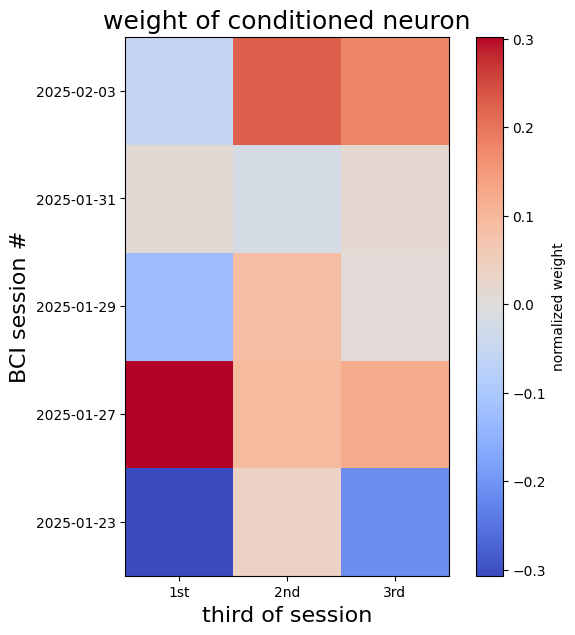

In [81]:

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(w_normalized, origin='lower', cmap='coolwarm')
ax.set_ylabel('BCI session #', fontsize=16)
ax.set_xlabel('third of session', fontsize=16)
ax.set_yticks(np.arange(0, 5, 1))
ax.set_yticklabels([s.date for s in sesh_dicts])
ax.set_xticks(np.arange(0, 3, 1))
ax.set_xticklabels(["1st", "2nd", "3rd"])
ax.set_title('weight of conditioned neuron', fontsize=18)
cbar = fig.colorbar(im)
cbar.set_label('normalized weight')
plt.savefig(f'{os.getcwd()}/samples_weight_distributions/{sesh_1.mouse_id}_cn_across_trials', dpi=200, bbox_inches='tight')

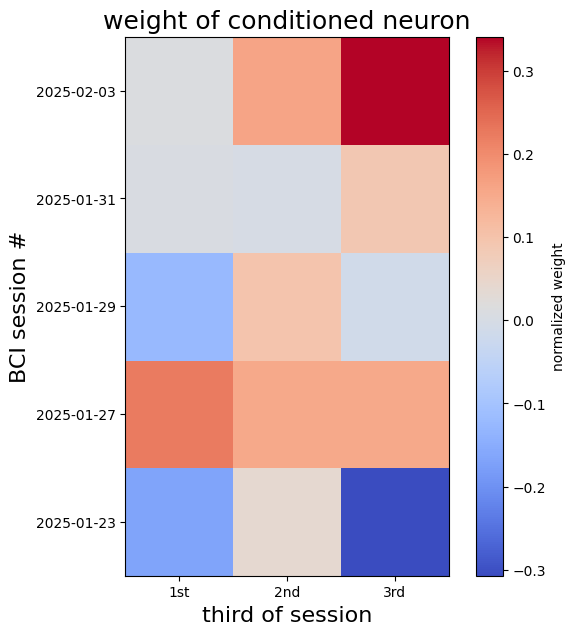

In [50]:

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(w_normalized, origin='lower', cmap='coolwarm')
ax.set_ylabel('BCI session #', fontsize=16)
ax.set_xlabel('third of session', fontsize=16)
ax.set_yticks(np.arange(0, 5, 1))
ax.set_yticklabels([s.date for s in sesh_dicts])
ax.set_xticks(np.arange(0, 3, 1))
ax.set_xticklabels(["1st", "2nd", "3rd"])
ax.set_title('weight of conditioned neuron', fontsize=18)
cbar = fig.colorbar(im)
cbar.set_label('normalized weight')
plt.savefig(f'{os.getcwd()}/weight_distributions/{sesh_1.mouse_id}_cn_across_trials', dpi=200, bbox_inches='tight')

# ~svm model scores~

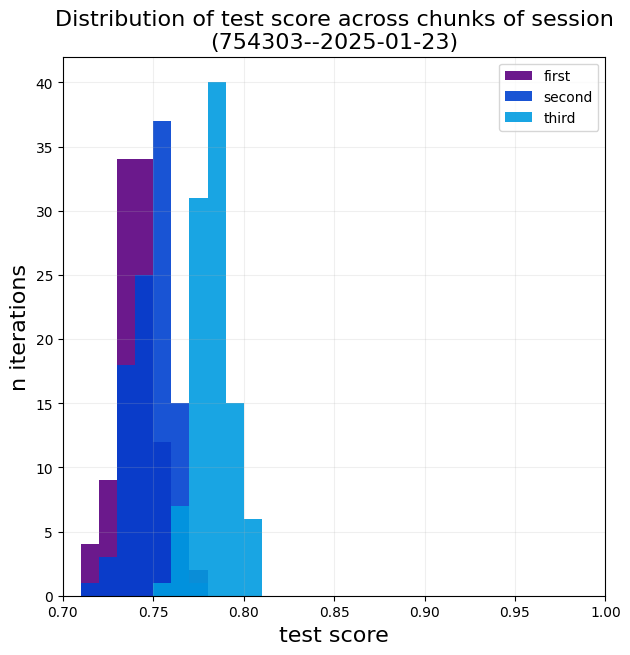

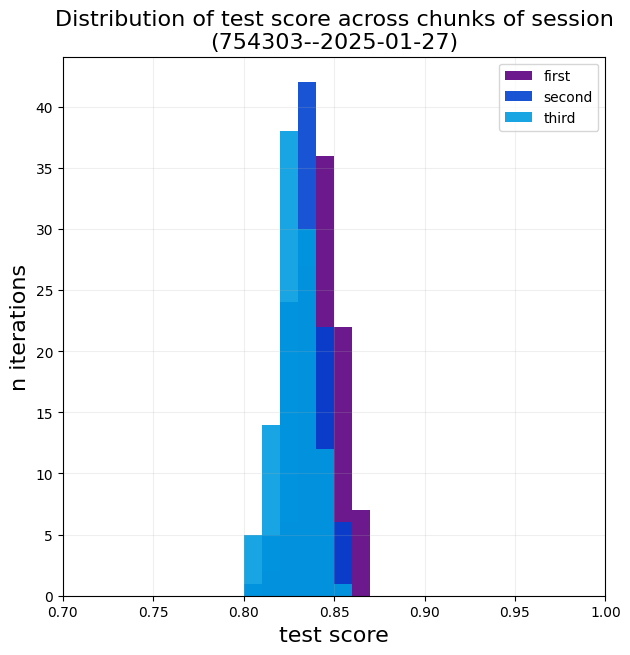

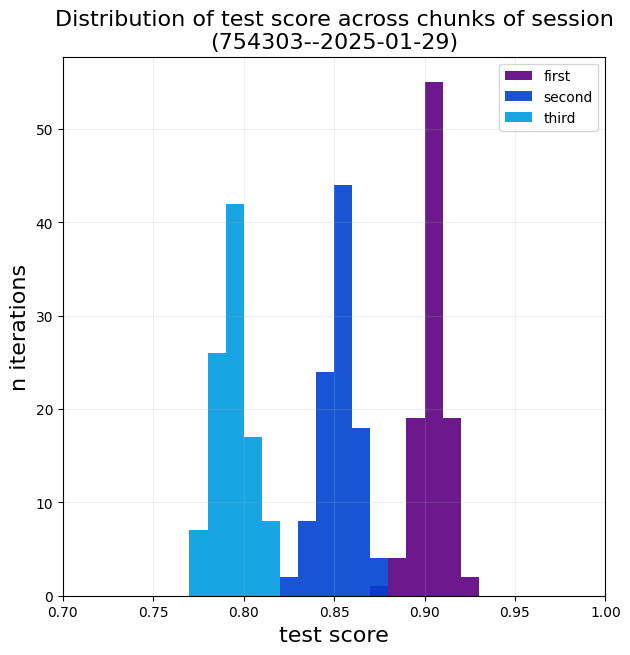

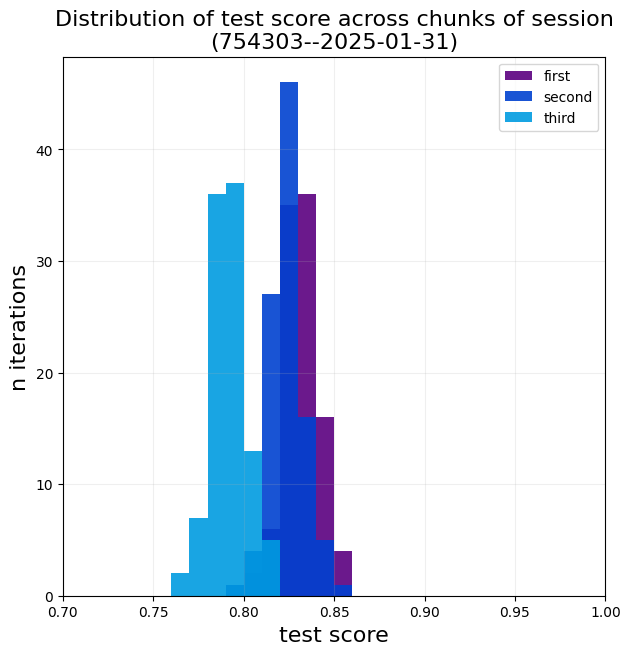

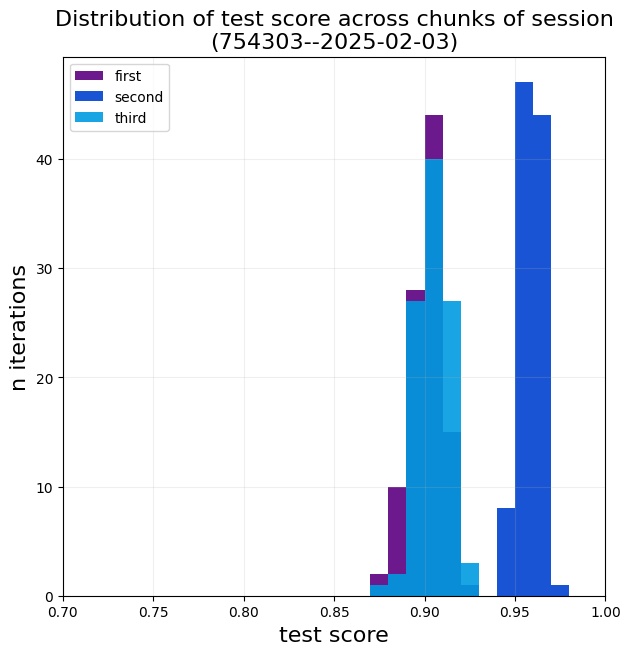

In [442]:
for s in sesh_dicts:
    fig, ax = plt.subplots(figsize=(7, 7,))

    ax.hist(s.score_test[:, 0], label='first', color='#5B0080', alpha=0.9, bins=np.arange(0.7, 1, 0.01))
    ax.hist(s.score_test[:, 1], label='second', color='#0041D0', alpha=0.9, bins=np.arange(0.7, 1, 0.01))
    ax.hist(s.score_test[:, 2], label='third', color='#009BE0', alpha=0.9, bins=np.arange(0.7, 1, 0.01))
    ax.set_xlabel('test score', fontsize=16)
    ax.set_ylabel('n iterations', fontsize=16)
    ax.set_xlim(0.7,1)
    ax.grid(which='both', alpha=0.2)
    ax.set_title(f'Distribution of test score across chunks of session\n({s.mouse_id}--{s.date})', fontsize=16)
    ax.legend()
    plt.savefig(f'{os.getcwd()}/samples_weight_distributions/{s.mouse_id}_{s.date}_test_score_hist.png', dpi=200, bbox_inches='tight')

# distance v weight

In [84]:
md = load.load_filtered_metadata()
md = md[md['subject_id'] == mouse_id]
valid_sesh_list = np.sort(md['name'].values)[1:]
sesh = valid_sesh_list[0]

In [86]:
data = load.load_session_data(sesh)

BCI data directory: /data/brain-computer-interface

Session directory: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-23_19-48-32_processed_2025-08-08_15-29-29

NWB file: single-plane-ophys_754303_2025-01-23_19-48-32_behavior_nwb
NWB path: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-23_19-48-32_processed_2025-08-08_15-29-29/single-plane-ophys_754303_2025-01-23_19-48-32_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


All threshold files for mouse 754303: ['single-plane-ophys_754303_2025-01-27', 'single-plane-ophys_754303_2025-01-23', 'single-plane-ophys_754303_2025-01-29', 'single-plane-ophys_754303_2025-01-31', 'single-plane-ophys_754303_2025-02-03']

Found threshold file at: /data/bci-thresholds/single-plane-ophys_754303_2025-01-23
total difference in dataframes: 4
